In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
import cv2
from csbdeep.utils import Path, download_and_extract_zip_file

from nurisc import fill_label_holes, relabel_image_nurisc, random_label_cmap
from nurisc.matching import matching_dataset

np.random.seed(42)
lbl_cmap = random_label_cmap()

C:\Users\es255022\AppData\Local\Temp\ipykernel_26548\1818035050.py:4: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [3]:
#pannuke dataset

import requests
from tqdm import tqdm
import os
from zipfile import ZipFile
import io
from PIL import Image
import numpy as np

def download(url, file_name = None, chunk_size = 8192):
    if file_name is None:
        file_name = url.split('/')[-1]

    headers = {'user-agent': 'Wget/1.16 (linux-gnu)'}
    r = requests.head(url)
    file_size = int(r.headers['content-length'])
    r = requests.get(url, stream=True, headers=headers)

    with tqdm(total = file_size, desc=file_name, position=0, leave=True) as pbar:
        with open(file_name, 'wb') as f:
            for chunk in r.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(chunk_size)


url = "https://warwick.ac.uk/fac/sci/dcs/research/tia/data/pannuke/fold_1.zip" #@param {type:"string"}
#Training_source = "/content/gdrive/MyDrive/projects/nurisc/pannuke" #@param {type:"string"}
#Training_target = "/content/gdrive/MyDrive/projects/nurisc/output" #@param {type:"string"}

file_name = url.split('/')[-1]
if not os.path.exists(file_name):
    download(url)

# Some inspiration from https://thispointer.com/python-how-to-unzip-a-file-extract-single-multiple-or-all-files-from-a-zip-archive/
with ZipFile(file_name, 'r') as zipObj:
    # Get a list of all archived file names from the zip
    listOfFileNames = zipObj.namelist()

    with tqdm(total = len(listOfFileNames), desc="Extracting", position=0, leave=True) as pbar:
        for fileName in listOfFileNames:
            if ".npy" in fileName:
                pbar.set_description("Extracting %s" % fileName)
                d,fn = os.path.split(fileName)
                prefix = d.split("/")[-1]
                if not os.path.exists(os.path.join('/content',fn)):
                    zipInfo = zipObj.getinfo(fileName)
                    zipInfo.filename = fn
                    zipObj.extract(zipInfo, '/content')
            pbar.update()

    types = np.load("/content/types.npy",mmap_mode='r')
    images = np.load("/content/images.npy",mmap_mode='r')
    masks = np.load("/content/masks.npy",mmap_mode='r')

    if not os.path.exists(Training_source):
        os.mkdir(Training_source)

    if not os.path.exists(Training_target):
        os.mkdir(Training_target)

    n_images = images.shape[0]
    n_images = 250 #comment this out if you need all the images

    with tqdm(total = n_images, desc="Converting", position=0, leave=True) as pbar:
        for i in range(n_images):
            fn = prefix + "_" + types[i] + "_%d.tif" % i
            pbar.set_description("Saving %s" % fn)

            im = Image.fromarray(images[i,...].astype(np.uint8))
            pno = os.path.join(Training_source,fn)
            im.save(pno,compression=None)
            # `masks.npy` an array of 6 channel instance-wise masks (0: Neoplastic cells, 1: Inflammatory, 2: Connective/Soft tissue cells, 3: Dead Cells, 4: Epithelial, 6: Background)
            mask = np.zeros((256,256),np.uint8)
            tmax = 0
            for j in range(5):
                tmask = masks[i,:,:,j]
                nz = np.nonzero(tmask)
                if nz[0].shape[0] > 0:
                    mask[nz] = tmask[nz]+tmax
                    tmax += np.max(tmask)

            im = Image.fromarray(mask.astype(np.uint8))
            pno = os.path.join(Training_target,fn)
            im.save(pno,compression=None)

            pbar.update()

KeyError: 'content-length'

In [2]:
download_and_extract_zip_file(
    url       = 'https://github.com/nurisc/nurisc/releases/download/0.1.0/dsb2018.zip',
    targetdir = 'data',
    verbose   = 1,
)

Files missing, downloading... extracting... done.


In [20]:
# X = sorted(glob('data/dsb2018/train/images/*.tif'))
# Y = sorted(glob('data/dsb2018/train/masks/*.tif'))

X= sorted(glob('C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data/*.png'))
Y= sorted(glob('C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data1/*.png'))
print(len(X))
print(len(Y))
# print(X.shape)
# print(Y.shape)
# assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

24
24


Load only a small subset

In [24]:
#PANNUKE
X=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/images/fold3/images.npy')
Y1=np.load('C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/pannuke/fold_3/Fold 3/masks/fold3/masks.npy')
Y=Y1.astype(int)
Y = [y[...,0] for y in Y]
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

In [25]:
print(X[0].shape)
print(Y[0].shape)

(256, 256, 3)
(256, 256)


In [26]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from nurisc import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from nurisc.matching import matching, matching_dataset
from nurisc.models import Config2D, nurisc2D, nuriscData2D

np.random.seed(42)
lbl_cmap = random_label_cmap()

222649726.py (5): Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [27]:
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

Normalizing image channels independently.



100%|██████████| 2722/2722 [00:26<00:00, 102.00it/s]

100%|██████████| 2722/2722 [00:03<00:00, 837.69it/s]


In [28]:
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    # im = ai.imshow(img, clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


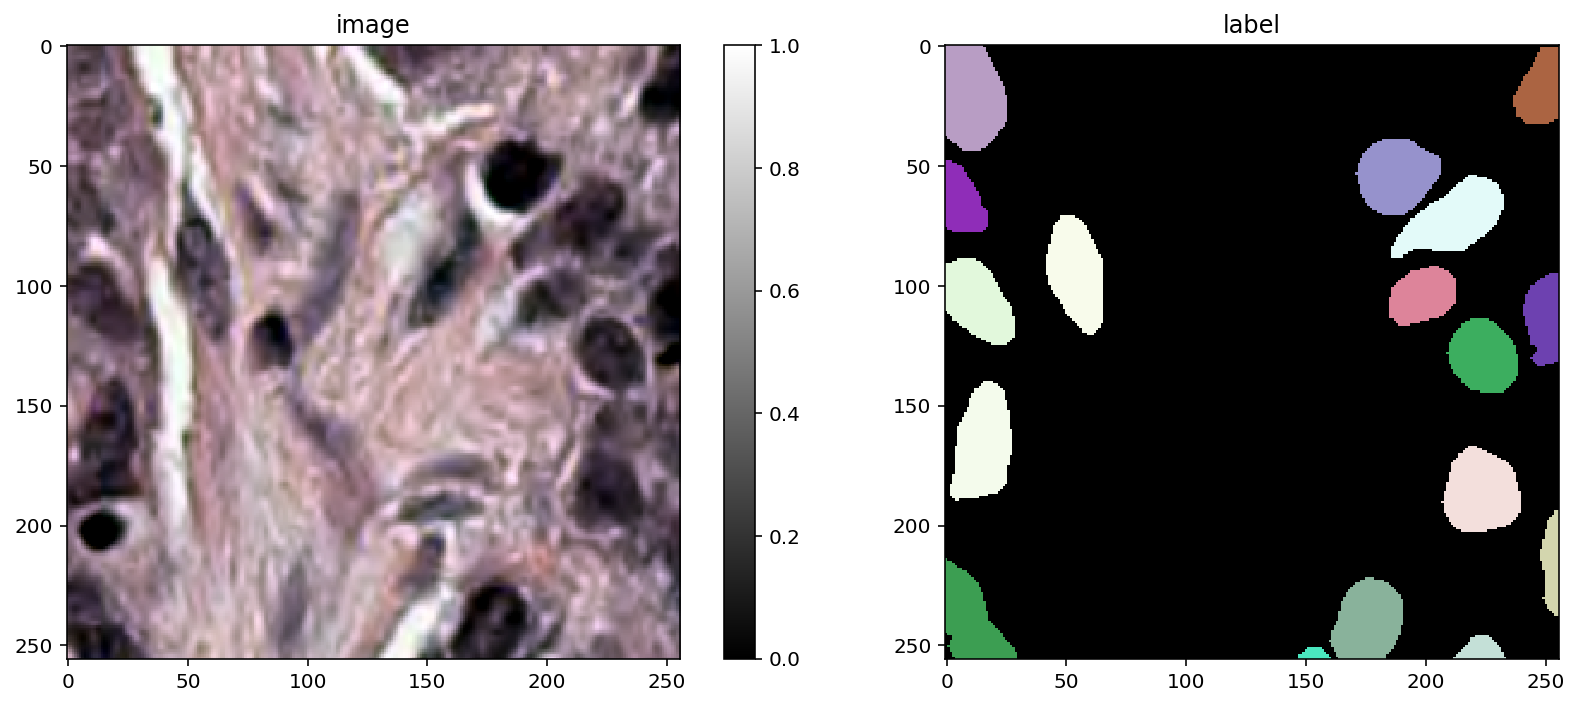

In [30]:
i = min(100, len(X)-1)
img, lbl = X[i], Y[i]
# print(lbl.shape)
# print(max(lbl[120]))
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plot_img_label(img,lbl)
None;

In [ ]:
import cv2
import os
from os import listdir,makedirs
from os.path import isfile,join

# Replace mydir with the directory you want
path = r'C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/processed-original-monuseg/train/masks1/' # Source Folder
dstpath = r'C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data1'

try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in asme folder")

# files = os.listdir(path)

files = os.listdir(path)

for image in files:
    img = cv2.imread(os.path.join(path,image))
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(dstpath,image),gray)

In [ ]:
for i in range(0, len(X)-1):


In [4]:
X, Y = X[:10], Y[:10]
print(X)
print(Y)


[[[[191. 154. 184.]
   [191. 154. 184.]
   [191. 154. 184.]
   ...
   [195. 134. 164.]
   [192. 131. 162.]
   [193. 132. 164.]]

  [[191. 154. 184.]
   [191. 154. 184.]
   [191. 154. 184.]
   ...
   [195. 134. 164.]
   [192. 131. 162.]
   [193. 132. 164.]]

  [[193. 156. 186.]
   [191. 154. 184.]
   [189. 152. 182.]
   ...
   [198. 130. 161.]
   [194. 128. 158.]
   [194. 129. 160.]]

  ...

  [[214. 163. 190.]
   [219. 169. 196.]
   [217. 167. 195.]
   ...
   [193. 144. 182.]
   [191. 141. 179.]
   [192. 141. 180.]]

  [[213. 159. 188.]
   [217. 164. 192.]
   [216. 164. 193.]
   ...
   [193. 145. 182.]
   [193. 144. 182.]
   [194. 145. 183.]]

  [[206. 150. 179.]
   [211. 156. 185.]
   [214. 160. 189.]
   ...
   [194. 147. 183.]
   [195. 148. 184.]
   [195. 147. 184.]]]


 [[[159. 116. 151.]
   [159. 116. 151.]
   [163. 122. 156.]
   ...
   [185. 125. 158.]
   [187. 128. 161.]
   [186. 129. 162.]]

  [[156. 114. 148.]
   [156. 114. 148.]
   [157. 115. 149.]
   ...
   [180. 121. 154.]
 

In [21]:
import scipy.io as sio
import os
# from tifffile import imread
from cv2 import imread

# X = list(map(imread(X)))
X=list(map(imread,X))
# from scipy.ndimage import imread
Y = list(map(imread,Y))

# print(Y[0].shape)

In [5]:
print(X[0].shape)
print(Y[0].shape)

(256, 256, 3)
(256, 256)


In [35]:
from PIL import Image
im_gray = np.array(Image.open('C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data/0001.png').convert('L'))

print(im_gray.shape)
im_gray_mask = np.array(Image.open('C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data1/0001.png').convert('L'))
Y=im_gray_mask
print(im_gray.shape)
print(im_gray_mask.shape)

(256, 256)
(256, 256)
(256, 256)


In [30]:
for i in range(0,len(X)):
    X[i]=X[i].reshape(256,256, -1)
    Y[i]=Y[i].reshape(256,256, -1)

ValueError: cannot reshape array of size 196608 into shape (256,256)

In [34]:
import os,cv2
path = r'C:/Users/es255022/OneDrive - Teradata/Desktop/Dataset/processed-original-monuseg/train/masks' # Source Folder
dstpath = r'C:/Users/es255022/PycharmProjects/pCDNet/nurisc-master/examples/2D/converted_data2' # Destination Folder

from PIL import Image


try:
    os.makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in asme folder")

# Folder won't used
files = os.listdir(path)
Y=im_gray
for image in files:
    # img = cv2.imread(os.path.join(path,image))
    im_gray = np.array(Image.open(img).convert('L'))
    # gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(dstpath,im_gray))

Directory already exist, images will be written in asme folder


AttributeError: 'numpy.ndarray' object has no attribute 'read'

    # Example image

In [10]:
i = min(1000, len(X)-1)
img=X[i]
img, lbl = X[i], fill_label_holes(Y[i])
# img,lbl=img,fill_label_holes(lbl)
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
# assumed axes ordering of img and lbl is: YX(C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


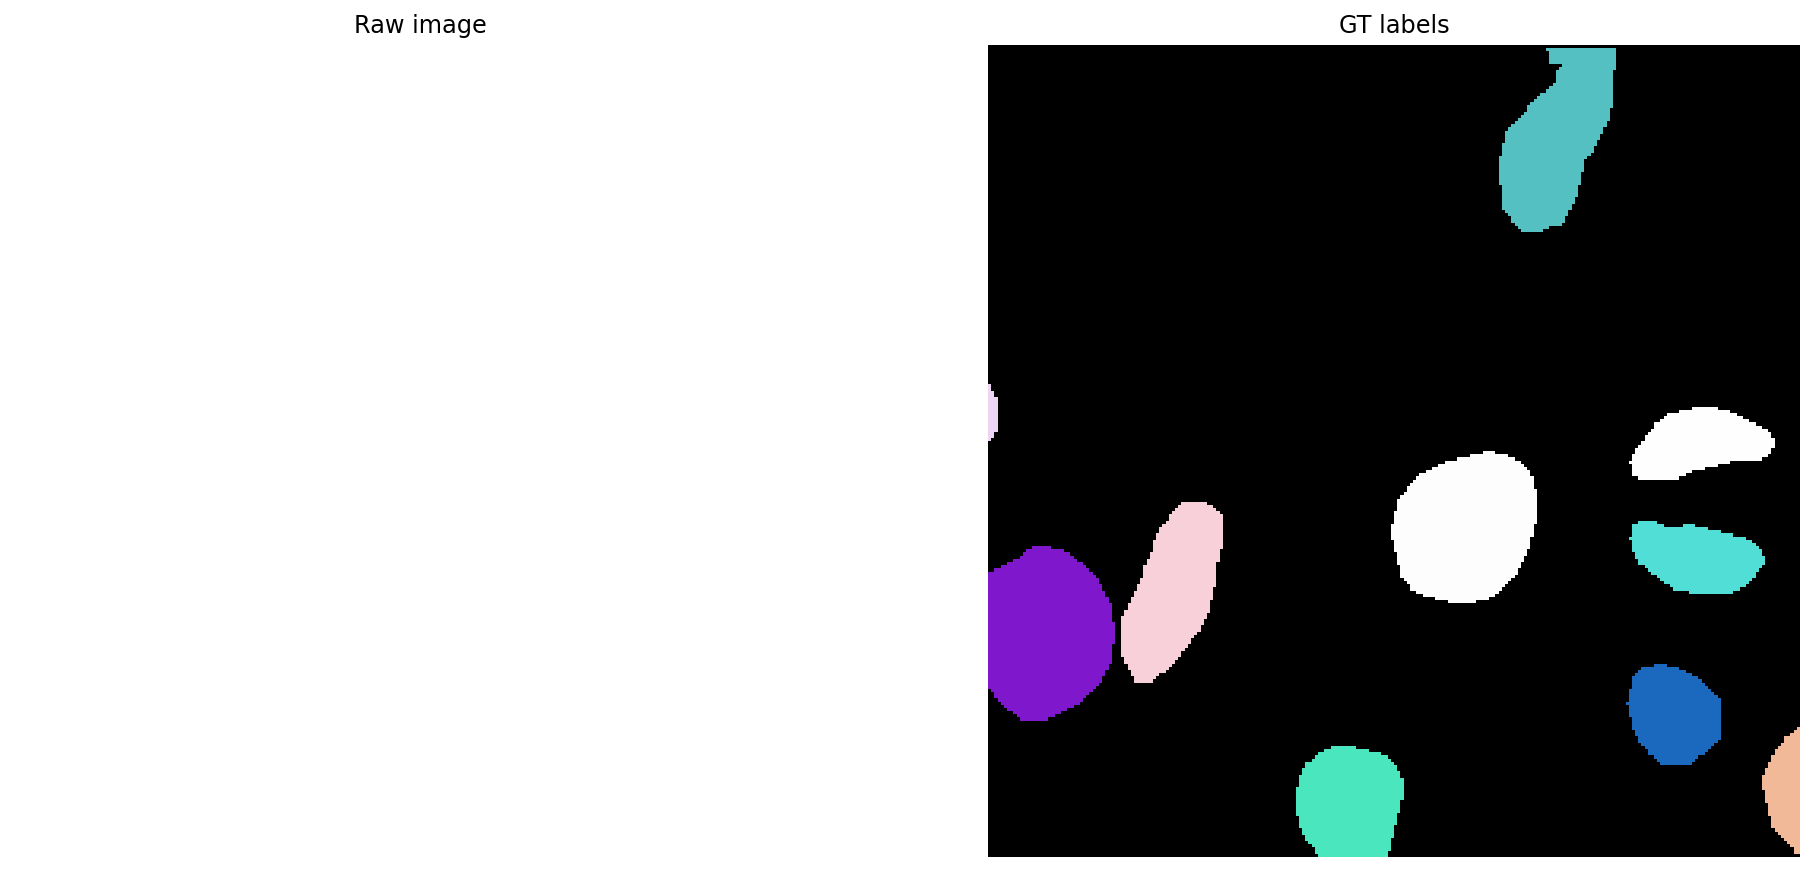

In [11]:
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

# Fitting ground-truth labels with star-convex polygons

In [32]:
n_rays = [2**i for i in range(2,8)]
print(n_rays)
scores = []
for r in tqdm(n_rays):

     # Y_reconstructed = [relabel_image_nurisc(lbl, n_rays=r) for lbl in Y]
    Y_reconstructed = relabel_image_nurisc(lbl, n_rays=r)
    mean_iou = matching_dataset(img, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    scores.append(mean_iou)
    # Y_reconstructed = [relabel_image_nurisc(lbl, n_rays=r) for lbl in Y]
    #
    # mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
    # scores.append(mean_iou)

[4, 8, 16, 32, 64, 128]



  0%|          | 0/6 [00:00<?, ?it/s]


ValueError: y_true must be an array of non-negative integers.

In [40]:
%load_ext tensorboard
import numpy as np
import sys
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file, normalize
from datetime import datetime

from nurisc import relabel_image_nurisc3D, Rays_GoldenSpiral, calculate_extents
from nurisc import fill_label_holes, random_label_cmap
from nurisc.matching import matching, matching_dataset
from nurisc.models import Config3D, nurisc3D, nuriscData3D

np.random.seed(42)
lbl_cmap = random_label_cmap

def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = relabel_image_nurisc3D(lbl, rays)
        # Y_reconstructed = [relabel_image_nurisc3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(im_gray_mask, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [41]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.0040983606557377, 1.0)


In [42]:
n_rays = [8, 16, 32, 64, 96, 128]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

  0%|          | 0/6 [00:00<?, ?it/s]


ValueError: lbl image should be 3 dimensional

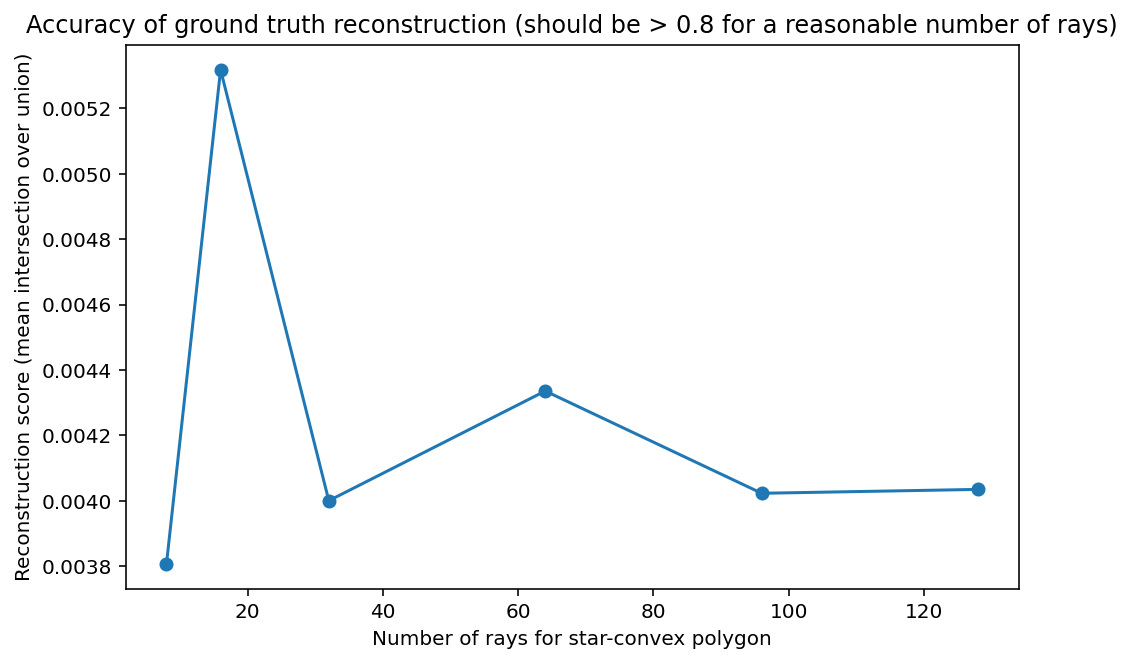

In [43]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

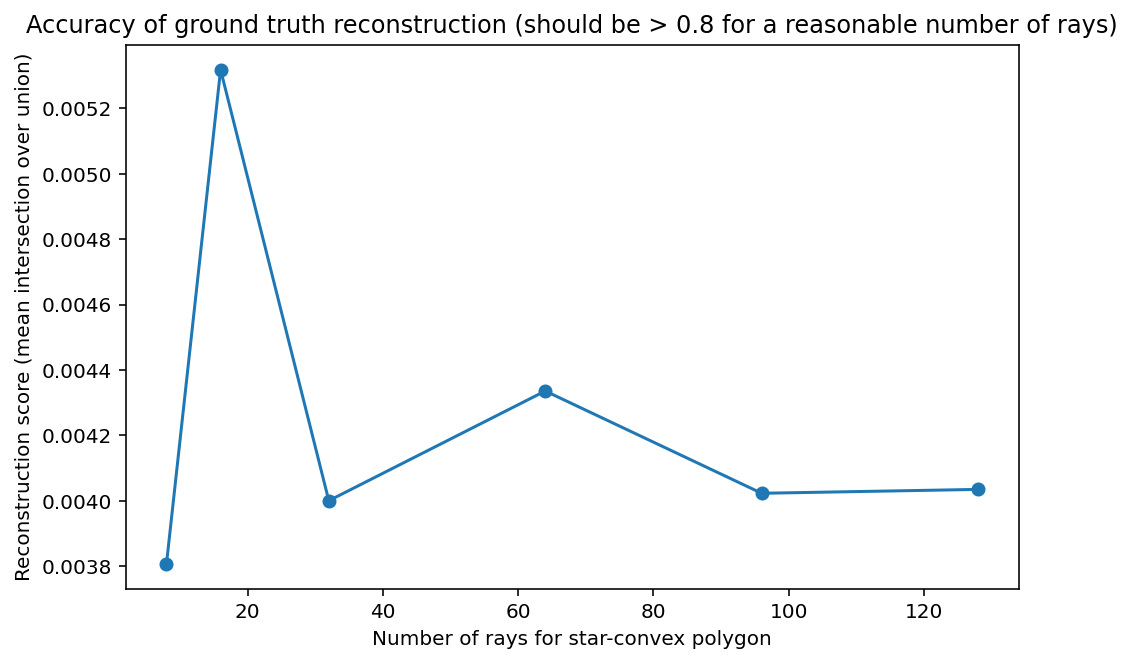

In [44]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores, 'o-')
plt.xlabel('Number of rays for star-convex polygon')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.title("Accuracy of ground truth reconstruction (should be > 0.8 for a reasonable number of rays)")
None;

## Example image reconstructed with various number of rays

ValueError: <function random_label_cmap at 0x0000020048BC3670> is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'

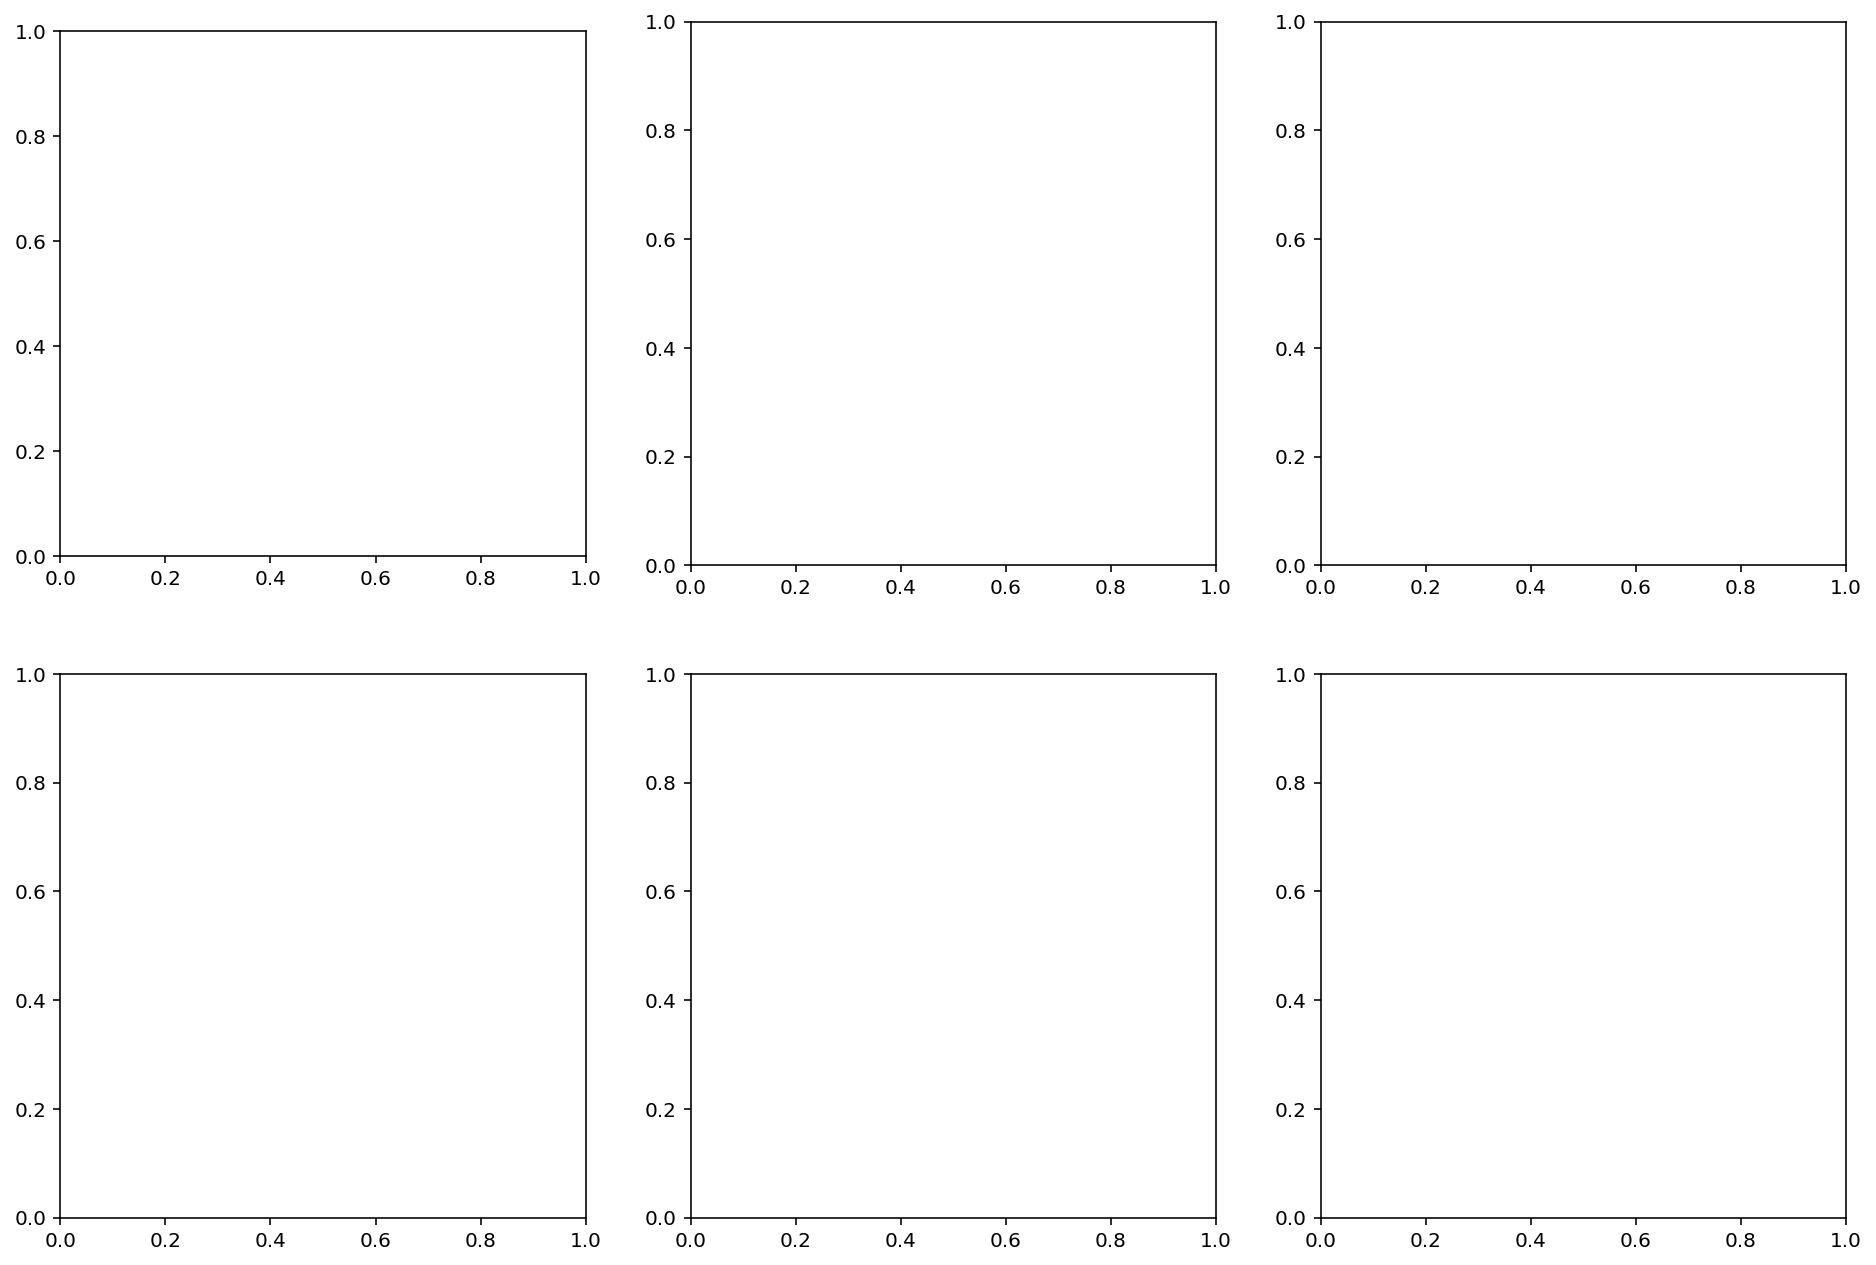

In [45]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    a.imshow(relabel_image_nurisc(lbl, n_rays=r), cmap=lbl_cmap)
    a.set_title('Reconstructed (%d rays)' % r)
    a.axis('off')
plt.tight_layout();